In [1]:
import torch
import torchaudio
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image

In [2]:
PATH = '/workspace/model/traffic_light_model.pth'

model = models.mobilenet_v2(pretrained=True)
NUM_CLASSES=4
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=NUM_CLASSES)

model.load_state_dict(torch.load(PATH, weights_only=True))
model.eval()

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

(1, 'green')

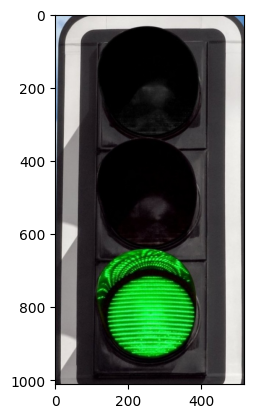

In [3]:
color = ["black", "green", "red", "orange"]

img = cv2.imread("/workspace/test_img/green.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)
plt.imshow(img)
input_tensor = transform(img)
input_tensor = input_tensor.to(device)
output = model(input_tensor.reshape(1, *input_tensor.shape))
i = np.argmax(output.cpu().detach().numpy()[0])
i, color[i]

# YoLo

In [7]:
from inference import get_model
import supervision as sv

In [5]:
img = cv2.imread("/workspace/test_img/test1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)

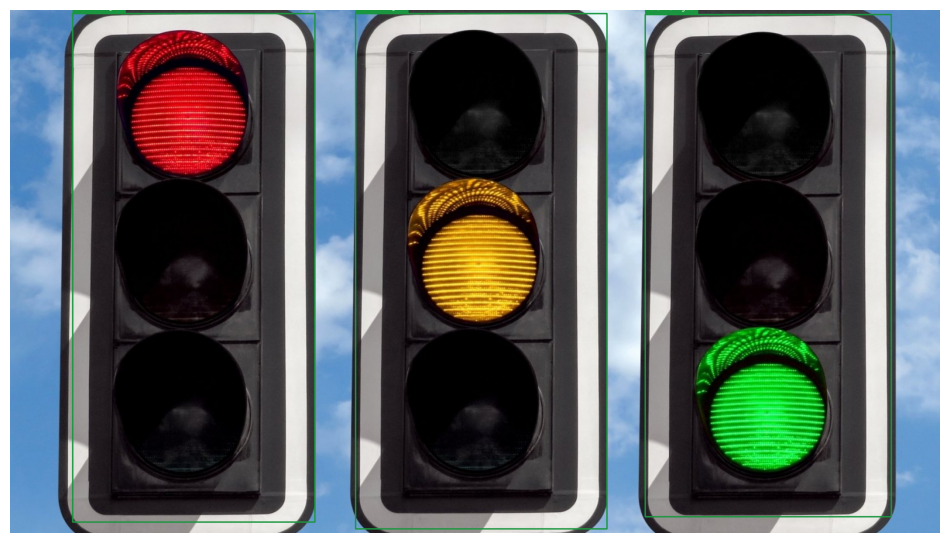

In [9]:
yolo = get_model(model_id="yolov11n-1280")

results = yolo.infer(img)[0]

# load the results into the supervision Detections api
detections = sv.Detections.from_inference(results)

# create supervision annotators
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# annotate the image with our inference results
annotated_image = bounding_box_annotator.annotate(scene=img, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

# display the image
sv.plot_image(annotated_image)

In [32]:
detections.xyxy

array([[ 713.,    9., 1232., 1071.],
       [1311.,   11., 1819., 1046.],
       [ 129.,    9.,  629., 1057.]])

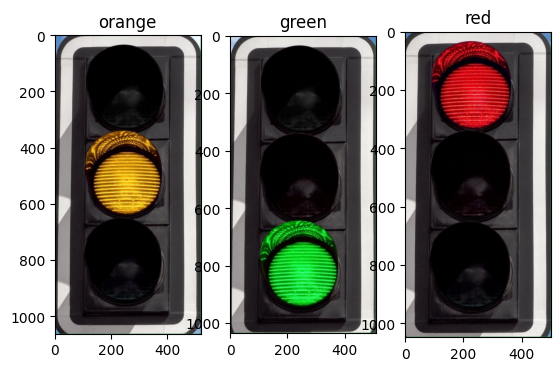

In [40]:
i=1
for d in detections.xyxy:
    plt.subplot(1,3,i)

    cropped = np.array(img)[int(d[1]):int(d[3]), int(d[0]):int(d[2])]
    _cropped = cropped.copy()

    cropped = Image.fromarray(cropped)
    input_tensor = transform(cropped)
    input_tensor = input_tensor.to(device)
    output = model(input_tensor.reshape(1, *input_tensor.shape))
    j = np.argmax(output.cpu().detach().numpy()[0])

    plt.title(color[j])
    plt.imshow(_cropped)
    i+=1